# CIS6800: Project 6: SegFormer

### Instructions:
* This is a group assignment with one submission per group. It is expected that each member of the group will contribute to solving each question. Be sure to specify your teammates when you submit to Gradescope! Collaborating with other groups is not permitted.
* There is no single answer to most problems in deep learning, therefore the questions will often be underspecified. You need to fill in the blanks and submit a solution that solves the (practical) problem. Document the choices (hyperparameters, features, neural network architectures, etc.) you made where specified.
* All the code should be written in Python.
* You may include any code used in previous projects.

## Introduction

SegFormer is a simple architecture with some key innovations that allow it to acheive state of the art performance at much higher speeds and fewer parameters than other competing methods. In this assignment, you will be implementing the building blocks of SegFormer. An overview of the architecture is provided below.

It is highly encouraged for you to review the SegFormer paper, available [here](https://arxiv.org/pdf/2105.15203.pdf). In particular, Section 3 contains detailed descriptions of the modules you will be implementing.

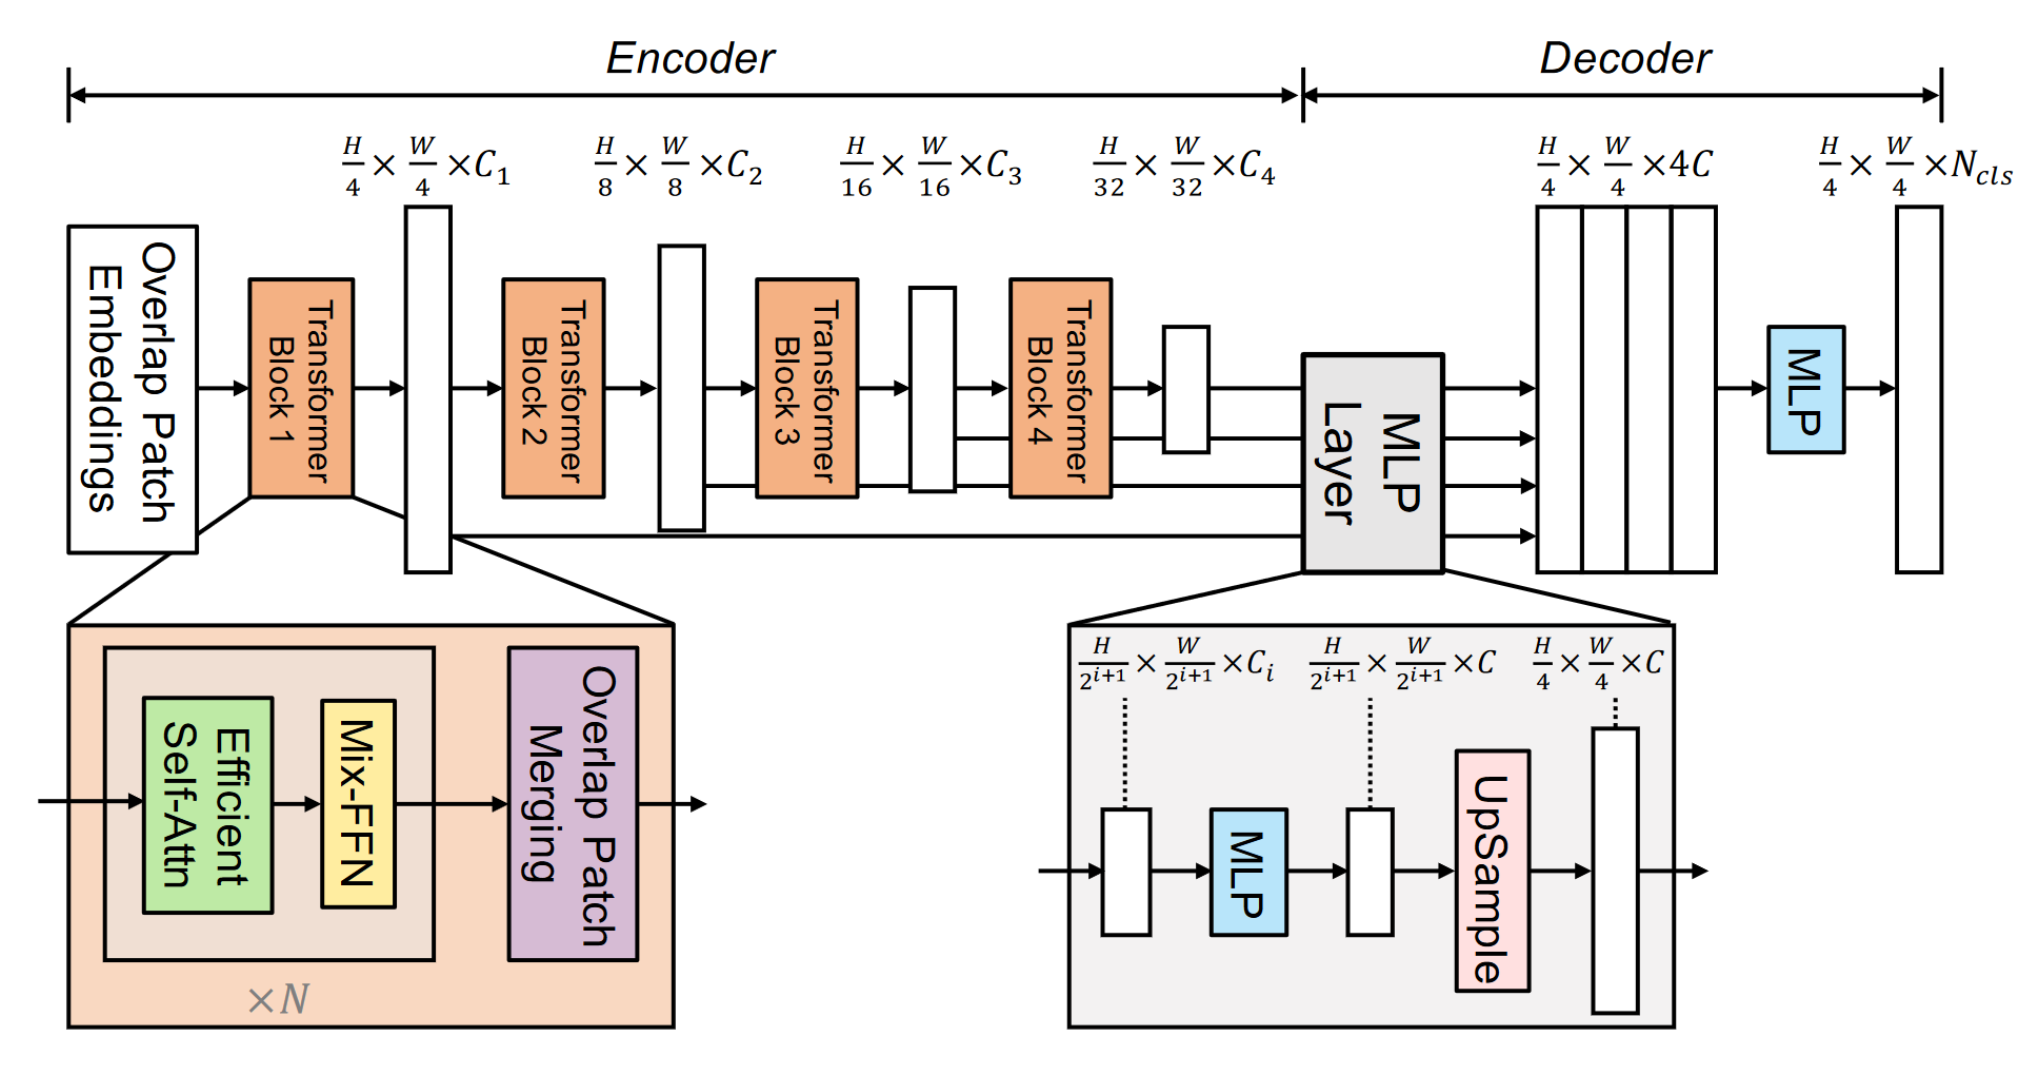

In [ ]:
!pip install pytorch-lightning torchbench

import torch
from torch import nn
import numpy as np
import pytorch_lightning as pl
from torchbench.datasets import ADE20K
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_tensor, pil_to_tensor, resize, normalize
from torchvision.transforms import InterpolationMode
from torch.utils.data import Subset, DataLoader
from tqdm import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 17.2 MB/s eta 0:00:00
  Created wheel for tabulate: filename=tabulate-0.8.3-py3-none-any.whl size=23374 sha256=6e101cab7e909aa930ab5e6e919b8ee0bce61dc3c5b5a71eb936468c2aa6aa97
  Stored in directory: /root/.cache/pip/wheels/ea/f4/08/6ac7d5e3a397d0e56

## Data
For this assignment, we will use a simplified subset of ADE20K containg approximately 11,000 images with only four classes: "plant", "person/animal", "vehicle", and "background". The data in composed of a semantic class for each pixel - there is no distinction between different instances of the same object, unlike in previous assignments.

The following code downloads the original dataset, processes it, and visualizes an example.

In [ ]:
def simple_ade20k_transforms(image, target):
    image = resize(to_tensor(image), (256, 256))
    image = normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    target = resize(pil_to_tensor(target), (64, 64), InterpolationMode.NEAREST)[0].long()
    # 0: background, -1: plant, -2: person/animal, -3: vehicle
    class_mapping = [(5, -1), (10, -1), (13, -2), (18, -1), (21, -3), (67, -1),
                     (77, -3), (84, -3), (91, -3), (103, -3), (104, -3), (127, -2), (128, -3)]
    for cm in class_mapping:
        target[target == cm[0]] = cm[1]
    target[target > 0] = 0
    target *= -1
    return image, target

In [ ]:
train_dataset = ADE20K('data', 'train', download=True, transforms=simple_ade20k_transforms)
val_dataset = ADE20K('data', 'val', transforms=simple_ade20k_transforms)

967385088it [00:26, 36980995.71it/s]                               


Extracting data/ADEChallengeData2016.zip to data


In [ ]:
def trim_dataset(dataset):
    valid_indices = []
    for entry in tqdm(range(len(dataset))):
        _, target = dataset[entry]
        if (target > 0).float().mean() > 0.01:
            valid_indices.append(entry)
    if len(dataset) > len(valid_indices):
        dataset = Subset(dataset, valid_indices)
    return dataset

train_dataset = trim_dataset(train_dataset)
val_dataset = trim_dataset(val_dataset)

  0%|          | 0/20210 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 2000/2000 [00:18<00:00, 109.87it/s]


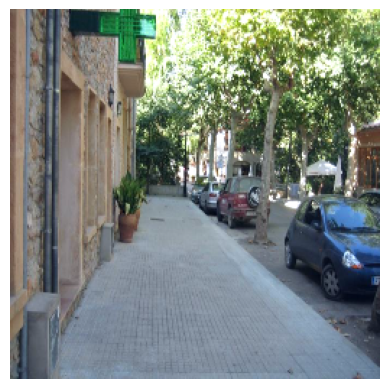

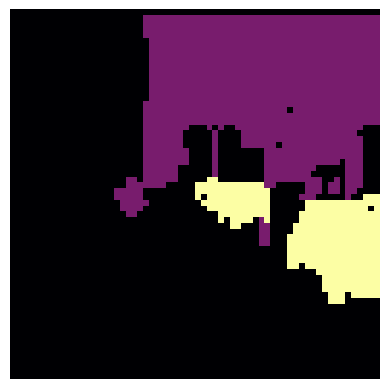

In [ ]:
idx = 2453
plt.imshow(train_dataset[idx][0].permute(1, 2, 0) / 4 + 0.5) # just for visualization
plt.axis('off')
plt.show()
plt.imshow(train_dataset[idx][1], vmin=0, vmax=3, cmap='inferno')
plt.axis('off')
plt.show()

## Modules
For this section, you will have to implement the base functionalities and modules for the SegFormer. As illustrated in the **Figure 2** and **Section 3** in the paper, we divide SegFormer into encoder-decoder sections. The encoder mainly consists of multiple layers of MixTransformerEncoderLayer, which then consists of OverlapPatchMergiing + (EfficientSelfAttention + MixFFN). While patch merging is relatively intuitive, you have to implement EfficientSelfAttention following **Equation 1** in the paper, and MixFFN as illustrated in **Equation 3**. On the other hand, the decoder section also consists of multiple decoder blocks, ending with a MLP. Refer to **Equation 4** for this part.

In [ ]:
# Combine adjacent patches to reduce feature map size, followed by LayerNorm
# Hint, patch merging can be accomplished with a single Conv2D module
class OverlapPatchMerging(nn.Module):
    def __init__(self, in_channels, out_channels, patch_size, stride, padding):
        super().__init__()
        # Define the conv2d layer to merge the patches
        self.conv2d = nn.Conv2d(in_channels, out_channels, patch_size, stride, padding, bias=False)

        # Define the layer normalization layer
        self.layernorm = nn.LayerNorm(out_channels)

    def forward(self, patches):
        """Merge patches to reduce dimensions of input.

        :param patches: tensor with shape (B, C, H, W) where
            B is the Batch size
            C is the number of Channels
            H and W are the Height and Width
        :return: tensor with shape (B, C, H, W)
        """
        x = self.conv2d(patches)
        B, C, H, W = x.shape

        # x = x.flatten(2).transpose(1, 2)

        # Normalize the output
        #
        x = x.permute(0, 2, 3, 1).reshape(B, H * W, C)  # (B, H'*W', C_out)

        # Normalize the output
        x = self.layernorm(x)
        # # Permute back to the original order
        # x = x.permute(0, 3, 1, 2)
        x = x.view(B, H, W, C).permute(0, 3, 1, 2)  # Reshape back to (B, C_out, H', W')

        return x

In [ ]:
# Perform attention with a reduced set of keys
# Hint, use a Linear layer followed by a LayerNorm before passing into MultiheadAttention
class EfficientSelfAttention(nn.Module):
    def __init__(self, channels, reduction_ratio, num_heads):
        super().__init__()
        assert channels % num_heads == 0, f"channels {channels} should be divided by num_heads {num_heads}."

        self.channels = channels
        self.reduction_ratio = reduction_ratio
        self.num_heads = num_heads
        self.reduced_dim = channels // reduction_ratio

        # Layers for reducing dimensionality of the keys
        self.key_reduce = nn.Linear(channels, self.reduced_dim, bias=False)
        self.key_norm = nn.LayerNorm(self.reduced_dim)

        # Layers for multihead attention
        self.query_transform = nn.Linear(channels, self.reduced_dim, bias=False)
        self.value_transform = nn.Linear(channels, self.reduced_dim, bias=False)
        self.attention = nn.MultiheadAttention(embed_dim=self.reduced_dim, num_heads=num_heads, batch_first=True)

        self.project_out = nn.Linear(self.reduced_dim, channels, bias=False)

    def forward(self, x):
        """ Perform self attention with reduced sequence length

        :param x: tensor of shape (B, N, C) where
            B is the batch size,
            N is the number of queries (equal to H * W)
            C is the number of channels
        :return: tensor of shape (B, N, C)
        """
        # Reduce the dimensionality of the keys
        k = self.key_reduce(x)
        k = self.key_norm(k)

        # Transform the queries and values
        q = self.query_transform(x)
        v = self.value_transform(x)

        # Apply multi-head attention with reduced keys and queries
        attn_output, _ = self.attention(query=q, key=k, value=v)
        attn_output = self.project_out(attn_output)
        output = attn_output + x

        return output

In [ ]:
# A feedforward network that mixes spatial information
# Should implement the following structure (inverse bottleneck):
#     mlp (channels -> expanded_channels)
#     depth-wise convolution (3 x 3)
#     activation function (gelu)
#     mlp (expanded_channels -> channels)
class MixFFN(nn.Module):
    def __init__(self, channels, expansion_factor):
        super().__init__()
        # Define the first MLP layer
        self.mlp1 = nn.Conv2d(channels, channels, kernel_size=1)

        # Define the depth-wise convolution layer
        self.dwconv = nn.Conv2d(
            channels, channels * expansion_factor, kernel_size=3, padding=1, groups=channels
        )

        # Define the activation function
        self.activation = nn.GELU()

        # Define the second MLP layer
        self.mlp2 = nn.Conv2d(channels * expansion_factor, channels, kernel_size=1)

    def forward(self, x):
        """ Perform self attention with reduced sequence length

        :param x: tensor with shape (B, C, H, W) where
            B is the Batch size
            C is the number of Channels
            H and W are the Height and Width
        :return: tensor with shape (B, C, H, W)
        """
        x = self.mlp1(x)

        x = self.dwconv(x)

        x = self.activation(x)

        x = self.mlp2(x)

        return x

In [ ]:
# Combine patch merging with n_layers of [attention followed by ffn]
class MixTransformerEncoderLayer(nn.Module):
    def __init__(self, in_channels, out_channels, patch_size, stride, padding,
                 n_layers, reduction_ratio, num_heads, expansion_factor):
        super().__init__()

        self.n_layers = n_layers

        # Define the patch merging module
        self.patch_merging = OverlapPatchMerging(in_channels, out_channels, patch_size, stride, padding)

        # Define separate lists for attention and FFN modules
        self.attention = EfficientSelfAttention(out_channels, reduction_ratio=reduction_ratio, num_heads=num_heads)

        self.ffn = MixFFN(out_channels, expansion_factor)


    def forward(self, x):
        """ Run one block of the mix vision transformer

        :param x: tensor with shape (B, C, H, W) where
            B is the Batch size
            C is the number of Channels
            H and W are the Height and Width
        :return: tensor with shape (B, C, H, W)
        """
        x = self.patch_merging(x)
        # print("After patch merging:", x.shape)


        for i in range(self.n_layers):
            B, C, H_prime, W_prime = x.shape
            x = x.flatten(2).transpose(1, 2)
            # print("Before attention:", x.shape)

            x = self.attention(x)
            # print("After attention:", x.shape)

            x = x.transpose(1, 2).view(B, C, H_prime, W_prime)
            # print("Before FFN:", x.shape)

            x = self.ffn(x)
            # print("After FFN:", x.shape)
        return x

In [ ]:
# Merge multiple feature maps and produce predictions
# Should implement the following structure
#     mlp_i (in_channels -> embed_channels)
#     usample and concatenate
#     mlp (m * embed_channels -> embed_channels)
#     batch norm and relu
#     mlp (embed_channels -> num_classes)
class MLPDecoder(nn.Module):
    def __init__(self, in_channels, embed_channels, out_dims, num_classes):
        """Initialize MLP Decoder.
        :param in_channels: list of int, number of input channels for each layeer
        :param embed_channels: int, common embedding channels
        :param out_dims: tuple, dimensions of common feature map
        """
        super().__init__()

        self.stages = nn.ModuleList([
            nn.Sequential(
                nn.Upsample(size=out_dims, mode='bilinear', align_corners=False),
                nn.Conv2d(in_c, embed_channels, kernel_size=1),
                nn.BatchNorm2d(embed_channels),
                nn.ReLU()
            ) for in_c in in_channels
        ])


        self.bn_relu = nn.Sequential(
            nn.Conv2d(len(in_channels) * embed_channels, embed_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(embed_channels),
            nn.ReLU()
        )

        self.final_mlp = nn.Conv2d(embed_channels, num_classes, kernel_size=1)


    def forward(self, x):
        """ Take feature map to common shape
        :param x: list of tensors with shape (B, Ci, Hi, Wi)
            B is the Batch size
            Ci is the number of input Channels
            Hi and Wi are the input Height and Width
        :return: tensor with shape (B, C, H, W)
            B is the Batch size
            C is the number of output Channels
            H and W are the input Height and Width
        """
        batch_size = x[0].size(0)

        # Upsample and reduce channel dimensions for each feature map
        processed_maps = [stage(feature_map) for feature_map, stage in zip(x, self.stages)]

        output = self.bn_relu(torch.cat(processed_maps, dim=1))

        output = self.final_mlp(output)

        return output

## Model and Training
We have provided you with a near-complete network template which you can indicate how a complete SegFormer is structured and how it calls the modules we have built. For validation step, you need to implement mean IoU as paper suggests.

In [ ]:
# This is implemented for you! Just implement the miou
class SegFormer_B0(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.encoder_blocks = nn.ModuleList([
            MixTransformerEncoderLayer(3, 32, patch_size=7, stride=4, padding=3, n_layers=2, reduction_ratio=8, num_heads=1, expansion_factor=8),
            MixTransformerEncoderLayer(32, 64, patch_size=3, stride=2, padding=1, n_layers=2, reduction_ratio=4, num_heads=2, expansion_factor=8),
            MixTransformerEncoderLayer(64, 160, patch_size=3, stride=2, padding=1, n_layers=2, reduction_ratio=2, num_heads=5, expansion_factor=4),
            MixTransformerEncoderLayer(160, 256, patch_size=3, stride=2, padding=1, n_layers=2, reduction_ratio=1, num_heads=8, expansion_factor=4)
        ])
        self.decoder = MLPDecoder([32, 64, 160, 256], 256, (64, 64), 4)
        self.loss = nn.CrossEntropyLoss()

        self.train_losses = []
        self.val_miou = []
        self.train_epoch = []
        self.miou_epoch = []

    def forward(self, images):
        embeds = [images]
        for block in self.encoder_blocks:
            embeds.append(block(embeds[-1]))
        return self.decoder(embeds[1:])

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=6e-5)
        return optimizer

    def miou(self, predictions, targets):
        predicted_classes = predictions.argmax(dim=1)
        total_classes = predictions.size()[1]
        valid_classes_count = total_classes
        mean_iou = 0
        epsilon = 1e-5

        for class_index in range(total_classes):
            target_mask = targets == class_index
            predicted_mask = predicted_classes == class_index

            # Skip class if it's not present in the ground truth
            if target_mask.sum() == 0:
                valid_classes_count -= 1
                continue

            intersection = torch.logical_and(predicted_mask, target_mask).sum().item()
            union = torch.logical_or(predicted_mask, target_mask).sum().item()
            mean_iou += intersection / (union + epsilon)

        # Calculate mean IoU over valid classes
        mean_iou /= valid_classes_count
        return mean_iou

    def training_step(self, batch, batch_idx):
        images, targets = batch
        predictions = self.forward(images)
        loss = self.loss(predictions, targets)
        self.log('train_loss', loss, prog_bar=True)
        self.train_losses.append(loss.detach().cpu())

        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        predictions = self.forward(images)
        miou = self.miou(predictions, targets)
        self.log('miou', miou, prog_bar=True)
        self.val_miou.append(miou)


    def on_train_epoch_end(self):
        self.train_epoch.append(np.mean(self.train_losses))
        self.train_losses = []


    def on_validation_epoch_end(self):
        self.miou_epoch.append(np.mean(self.val_miou))
        self.val_miou = []

In [ ]:
model = SegFormer_B0()
train_loader = DataLoader(train_dataset, batch_size=16)
val_loader = DataLoader(val_dataset, batch_size=16)

In [ ]:
trainer = pl.Trainer(devices=1, accelerator="gpu", max_epochs=10)
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type             | Params
----------------------------------------------------
0 | encoder_blocks | ModuleList       | 1.6 M 
1 | decoder        | MLPDecoder       | 397 K 
2 | loss           | CrossEntropyLoss | 0     
----------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.075     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  w

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


## Results
Show your training curves and results on several images from the validation set. Provide a qualitative description of the performance of your model. Don't forget to upsample your predicted segmentation mask to the same resolution as the image! Segformer indeed has achieved great performance, there is a short demo on Cityspaces-C corrupted dataset on [YouTube](https://www.youtube.com/watch?v=J0MoRQzZe8U').

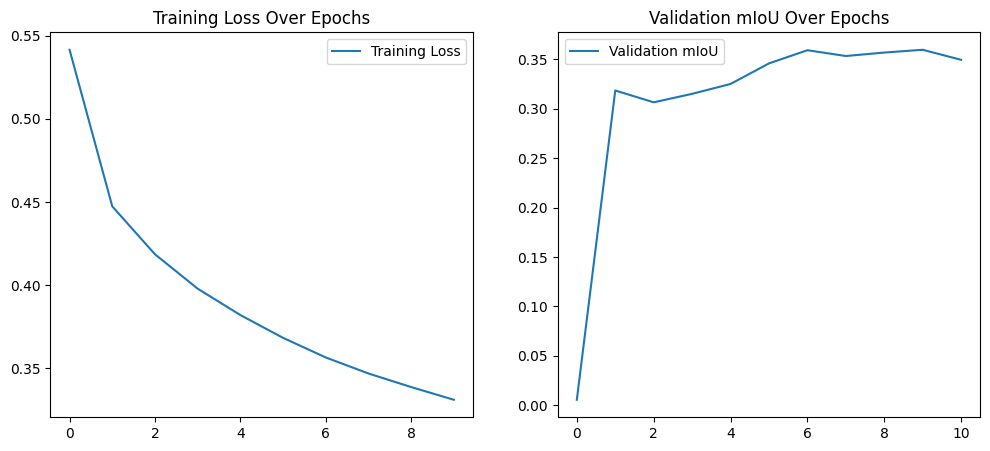

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(model.train_epoch, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model.miou_epoch, label='Validation mIoU')
plt.title('Validation mIoU Over Epochs')
plt.legend()

# plt.show()

In [ ]:
def denormalize(tensor, mean, std):
    if tensor.ndim == 4:  # Batch of images
        mean = mean[:, None, None]
        std = std[:, None, None]
    else:  # Single image
        mean = mean.view(-1, 1, 1)
        std = std.view(-1, 1, 1)
    return tensor * std + mean

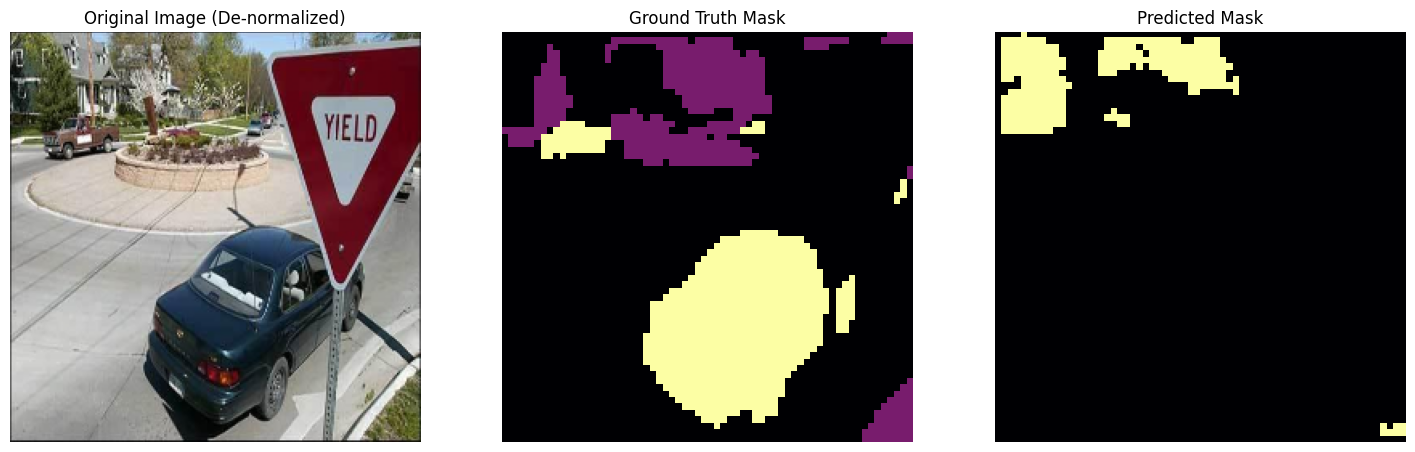

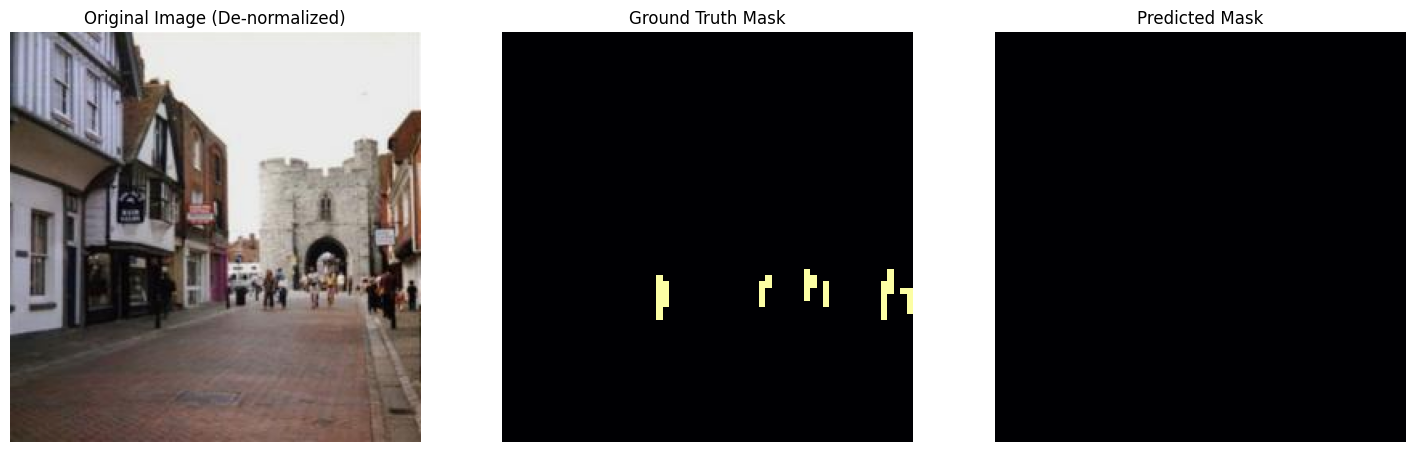

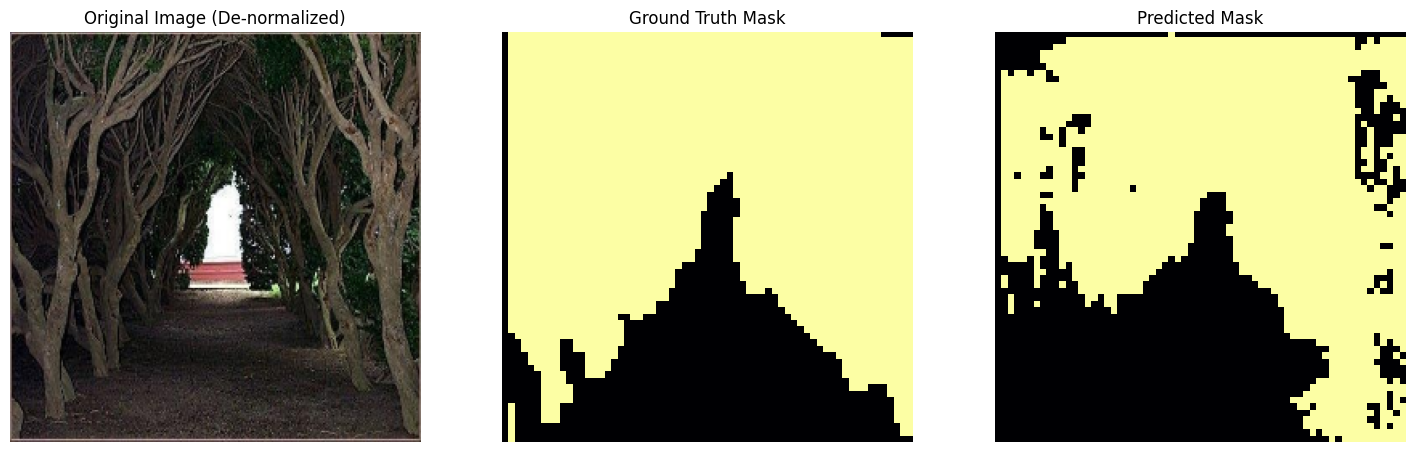

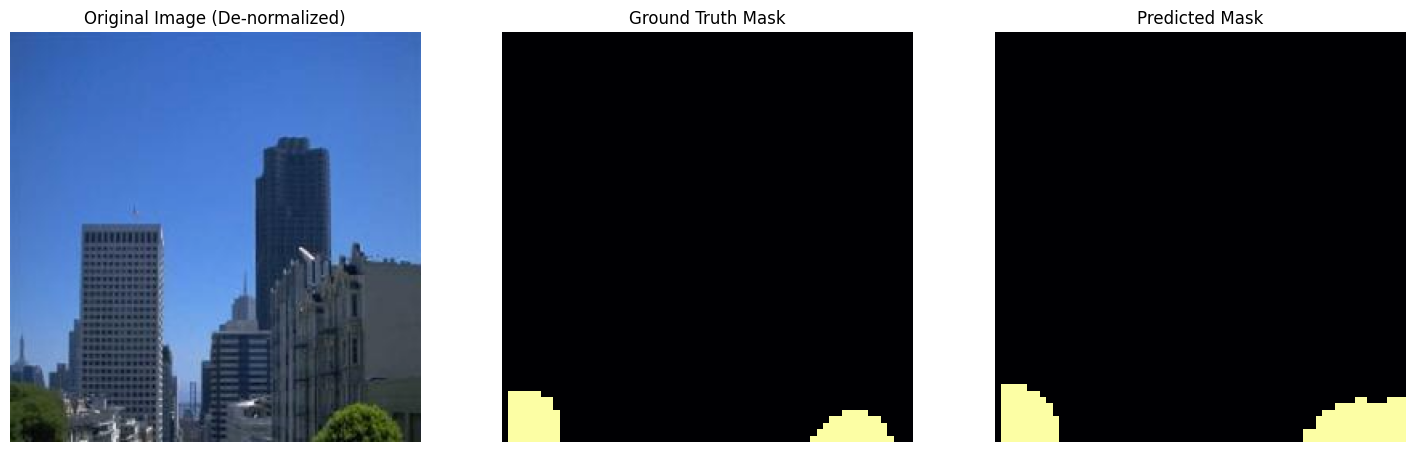

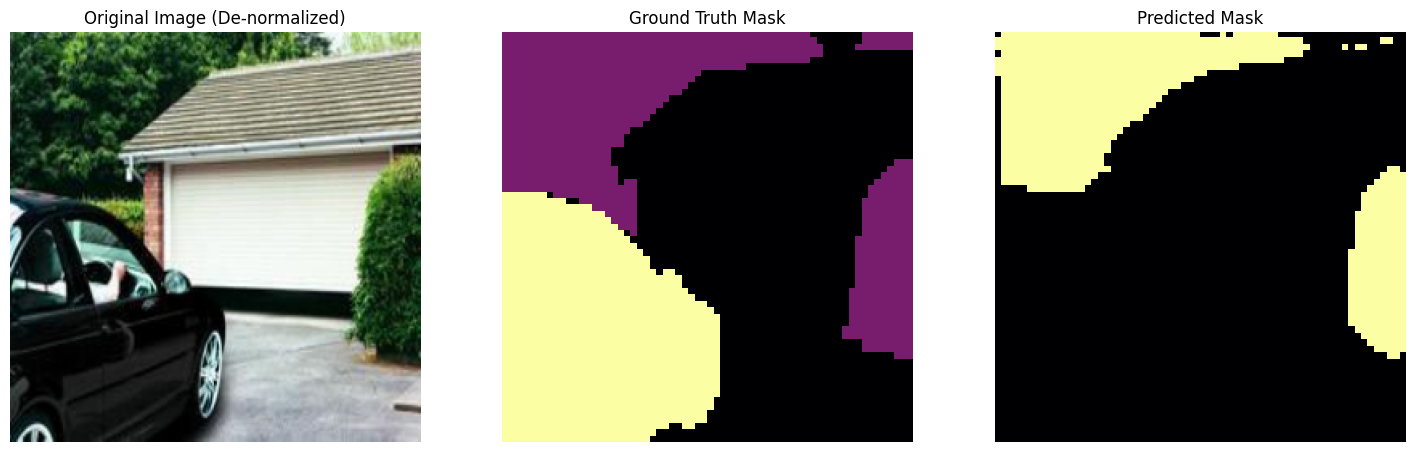

In [ ]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def visualize_predictions(model, val_loader, device, num_images=5):
    model.eval()  # Set the model to evaluation mode
    model.to(device)

    images, predictions, targets = [], [], []
    with torch.no_grad():
        for i, (image, target) in enumerate(val_loader):
            if i >= num_images:
                break
            image = image.to(device)
            pred = model(image)

            images.append(image.cpu())
            predictions.append(pred.cpu())
            targets.append(target.cpu())

    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])

    for i in range(5):
        plt.figure(figsize=(18, 6))

        # Original Image (De-normalized)
        denormalized_img = denormalize(images[i][0], mean, std)
        plt.subplot(1, 3, 1)
        plt.imshow(to_pil_image(denormalized_img))
        plt.title('Original Image (De-normalized)')
        plt.axis('off')

        # Ground Truth Mask
        plt.subplot(1, 3, 2)
        plt.imshow(targets[i][0], cmap='inferno')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        pred_class = torch.argmax(predictions[i][0], dim=0)
        plt.imshow(pred_class, cmap='inferno')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()

# Call the function to visualize the predictions
visualize_predictions(model, val_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

## Discussion Question
1. Why do we overlap and merge patches when reducing dimensions instead of e.g. max pool?
2. How does efficient self-attention affect the performance of the model?
3. Why do we only have one activation function in MixFFN?
4. If we removed padding='same' in MixFFN, would the performance of our model be affected? Why or why not? Suppose that there are no dimensional issues caused by this.
5. What is the difference between cross-entropy loss and miou? Why do we not use the miou to train?
6. Why are transformers especially suitable for this architecture? Namely, passing through different feature map stages and using a very small decoder. What problems might arise if we used convolutions instead?
7. Do you think that adding an FPN makes sense for this architecture? Justify your answer.
8. Your achieved performance is likely not very high, considering the simplicity of the data set. This assignment makes several simplications to the training process that contribute to this. Choose two such simplifications and explain why they degrade the achieved performance.

1) We overlap and merge patches for dimensionality reduction as opposed to max. pooling as it allows to retain more information from the input data. Since max pooling only keeps the max value within the video, it is prone to loosing important information. While overlap and merge for patches allows for better representation especially when we have overlapping patches.

2) Efficient Self Attention basically reduces the computational complexity and memory usage by reducing the number of operation needed for attention calculations. We did dimensionality reduction of keys and queries before applying attention mechanism.

3) We only use one activation function (GELU here) to introduce non-linearity to the model, while still keeping the model efficient.

4) Yes, removing `padding=same` will change the performance slightly as the model given no dimensional issues are caused by it. As this allows the model to still process the spatial information without changing the size of the output. But change in padding will slightly change how boundary information is handled.



5) Cross Entropy Loss measures the difference between the predicted probabilities and true labels, generally used for gradient based optimization. Whereas, mIoU is an evaluation metric that measures the overlap between predicted and actual class. Since it is not differentiable, we can't use it for loss function.

6) Transformers are especially suitable for this architecture due to their ability to capture long range dependencies and their global receptive field. Their self attention mechanism allows to process all parts of the input in relation to each other irrespective of their distance. If convolutions were used intead,we would face issues with the local receptive field and limitation to capturing long range dependencies without a complex model. CNNs can help gather local features but dto aggregate features globally, we would need much more complex model. Transformers can work with global aggregation more efficiently.  

7) Yes, adding FPN to this architecture makes sense as it provides complimentary strengths to Transformers. FPN can effectively aggregate multi-scale spatial information. Combining the ehances the model bu allowing it handle variations in object sizes and different scales. Further, FPN can also provide enhanced local-global feature integration as it integrates low level details with the high level semantic information.

8)
We didn't perform data augmentation. Data augmentation is beneficial as it perfors transformations, scaling and various other augmentations to enhance the diversity of the training set. Since we didn't perform it, the model might not learn those variations that can happen in the real world.

Additionally, we didn't try different optimization techniques when talking specifically about the training process. Using advanced optimization techniques could be effective in convergence to minimizing loss.